# ROC-AUC

In [10]:
import time
import numpy as np
from   matplotlib import pyplot as plt
from   sklearn.datasets import make_moons
from   sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from   sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

def shuffle_data(X,Y):
    idx = np.random.permutation(len(Y)) 
    return X[idx], Y[idx]        
    
#---------------------------------------------------------------------------------------

def eval_model(clf, X,Y, cv=20, prob = True, mix=True, info=""):
    if mix:
        X, Y = shuffle_data(X,Y)
        
    tm1 = time.process_time() 
    res = cross_validate(clf, X, Y, cv=cv, return_train_score=True)            
    tm2 = time.process_time() 
    acc_tst, acc_trn = res['test_score'],  res['train_score']
    
    clf.fit(X,Y)
    probs = clf.predict_proba(X)  if prob else [[0, 0]]
    probs = np.max(probs, axis=1)
    
    print(f"val: {acc_tst.mean():.3f} ± {acc_tst.std():.3f} [{acc_tst.min():.3f} ... {acc_tst.max():.3f}]   trn: {acc_trn.mean():.3f} ± {acc_trn.std():.3f}  [{acc_trn.min():.3f} ... {acc_trn.max():.3f}]  probs: {probs.mean():.3f} ± {probs.std():.3f}    {(tm2-tm1)/cv:.2f}s   {info}")
    return acc_tst.mean(),  acc_trn.mean(), probs.mean()

#---------------------------------------------------------------------------------------

def confusion(clf, X, Y):    
    
    cm = confusion_matrix(Y, clf.predict(X), normalize='true')
    
    plt.figure(figsize = (2,2), facecolor="w")
    sn.heatmap(cm, annot=True, cbar=False, annot_kws={"size": 16})
    plt.show()
    return cm
    
#---------------------------------------------------------------------------------------
    
def plot_data(X, Y, lim=(0.,1.), clf = None, num = 100, prob = True, title=""):                

    plt.figure (figsize=(4, 4), facecolor ='w')                                 
    
    if clf is not None:   
        x1 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x2 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x1, x2 =  np.meshgrid(x1, x2)            
        inp = np.c_[x1.ravel(), x2.ravel()]
        if prob:
            prob = clf.predict_proba(inp)[:,1].reshape(x1.shape)
            plt.imshow(prob, extent=[lim[0], lim[1], lim[0], lim[1]],  origin='lower', cmap='bwr', alpha=0.3)
            
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contour(x1, x2, label, cmap='gray')                
        else:        
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contourf(x1, x2, label, alpha=0.3, cmap='bwr')                
    
    plt.scatter(X[:,0], X[:,1], c=Y,  s=5, cmap='bwr')        
    plt.xlim(0, 1)
    plt.ylim(0, 1);
    plt.title(title)
    plt.show()                

#---------------------------------------------------------------------------------------
    
def my_auc(y_true, probs):
    x = probs[y_true == 0]                 # negative class probabilities
    y = probs[y_true == 1]                 # positive class probabilities
    z = np.array([np.tile  (x, len(y)),    # x0,x1,...x0,x1,...    
                  np.repeat(y, len(x))])   # y0,y0,y0,...,y1,y1,,    
    z = z.T                                # [x0,y0], [x0,y1], ..., [xn,ym]
    
    a = np.zeros_like(z)
    a[z[:,0] < z[:,1]]  = 1.0
    a[z[:,0] == z[:,1]] = 0.5

    return a.mean()    

#---------------------------------------------------------------------------------------

def plot_roc(X,Y, clf, probs = None):    
    if probs is None:
        probs = clf.predict_proba(X)[:, 1]
        
    fpr, tpr, thresholds = roc_curve(Y, probs)       # thresholds вероятности при которых получены fpr, tpr

    plt.figure(figsize=(5,5), facecolor ='w') 
    plt.plot(fpr, tpr)
    plt.xticks(np.linspace(0,1,11));  plt.yticks(np.linspace(0,1,11)); plt.grid()
    id1 = np.argmin(np.abs(thresholds - 0.5)) 
    plt.plot(fpr[id1], tpr[id1], 'o', markersize=5, fillstyle="none", c='k', mew=1) 

    plt.title(f"AUC:{roc_auc_score(Y, probs):.3f} {my_auc(Y, probs):.3f} ")
    plt.show()
    


## ROC для необученной модели

* Независимо от распределения вероятностей классов, если они не связаны с метками классов (модель ничему не научислась) - AUC=0.5
* Ошибка AUC примерно убывает, как обычно, как 1/N**0.5

0.5003


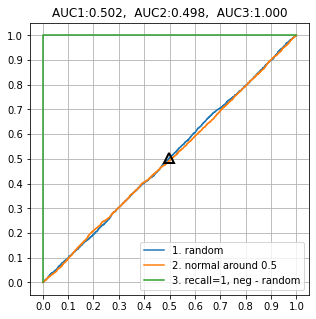

In [2]:
N = 10000
Y = np.random.randint(0, 2, (N,) )

probs1 = np.random.random ( (N,) )                   # равномерное распределение из [0..1]
probs2 = np.random.normal (0.5,0.1, (N,) ).clip(0,1) # в среднем 0.5 (с сигмой 0.1)

#probs3 = np.random.normal (0, 0.1, (N,) ).clip(0,1)  # или 0 или 1 с сигмой 0.1
#probs3[: N // 2] = np.random.normal (0.9, 0.1, (N // 2,) ).clip(0,1) 
probs3 = np.ones ( (N,) ) 
probs3[Y==0] = np.random.random ( ((Y==0).sum(),) )
print(accuracy_score(Y, probs3>0))

plt.figure(figsize=(5,5), facecolor ='w') 
fpr1, tpr1, thresholds1 = roc_curve(Y, probs1)       # thresholds вероятности при которых получены fpr, tpr
fpr2, tpr2, thresholds2 = roc_curve(Y, probs2) 
fpr3, tpr3, thresholds3 = roc_curve(Y, probs3) 
plt.plot(fpr1, tpr1 )
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.legend(["1. random", "2. normal around 0.5", "3. recall=1, neg - random"]); 

plt.xticks(np.linspace(0,1,11));  plt.yticks(np.linspace(0,1,11)); plt.grid()

id1 = np.argmin(np.abs(thresholds1 - 0.5)) 
plt.plot(fpr1[id1], tpr1[id1], '^', markersize=10, fillstyle="none", c='k', mew=2) 

plt.title(f"AUC1:{roc_auc_score(Y, probs1):.3f},  AUC2:{roc_auc_score(Y, probs2):.3f},  AUC3:{roc_auc_score(Y, probs3):.3f}")
plt.show()

0.75


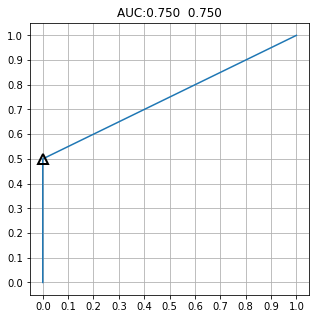

In [11]:
N = 10000
Y, probs = np.zeros((N,) ),  np.zeros((N,) )
Y[ : N//2] = 1
probs[: N//4] = 1

print(accuracy_score(Y, probs>0))

plt.figure(figsize=(5,5), facecolor ='w') 
fpr, tpr, thresholds = roc_curve(Y, probs)      
plt.plot(fpr, tpr)

plt.xticks(np.linspace(0,1,11));  plt.yticks(np.linspace(0,1,11)); plt.grid()

id1 = np.argmin(np.abs(thresholds - 0.5)) 
plt.plot(fpr[id1], tpr[id1], '^', markersize=10, fillstyle="none", c='k', mew=2) 

plt.title(f"AUC:{roc_auc_score(Y, probs):.3f}  {my_auc(Y, probs):.3f}")
plt.show()

## Dataset Moons

(500, 2) (500,)


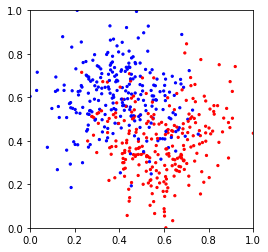

In [12]:
X, Y = make_moons(n_samples=500, noise=0.5, random_state=42)  # 

X = (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(X.shape, Y.shape)
plot_data(X,Y)

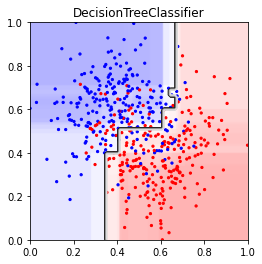

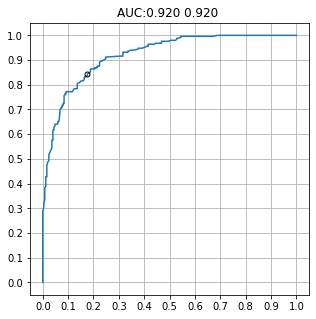

0.004 0.998
AUC:0.920 0.920 
0.763 0.964


In [13]:
from sklearn.ensemble import RandomForestClassifier 
 
clf = RandomForestClassifier(n_estimators=10,  min_samples_leaf = 20, random_state=0, max_features=2).fit(X,Y)

#eval_model(clf, X,Y, cv = 10)
plot_data(X, Y, clf=clf, title="DecisionTreeClassifier")     
plot_roc(X,Y, clf = clf)

probs = clf.predict_proba(X)[:, 1]
print(f"{probs.min():.3f} {probs.max():.3f}")
probs = np.tanh(probs+1)
print(f"AUC:{roc_auc_score(Y, probs):.3f} {my_auc(Y, probs):.3f} ")
print(f"{probs.min():.3f} {probs.max():.3f}")

Любые попытки самоcтоятельно сгенить вероятности - ухудшают AUC?

val: 0.808 ± 0.160 [0.400 ... 1.000]   trn: 0.828 ± 0.002  [0.822 ... 0.834]  probs: 0.816 ± 0.153    0.03s   


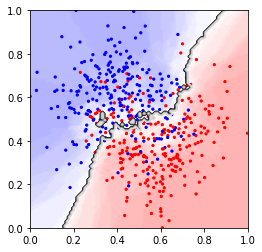

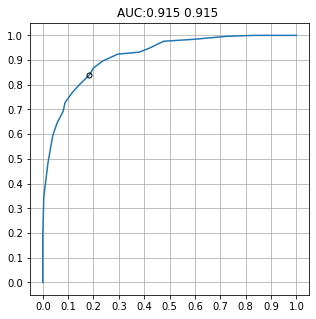

In [14]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 20)

eval_model(clf, X,Y, cv = 100)
plot_data(X, Y, clf = clf)  

Y_pred = clf.predict(X)
sigma = 1
probs =           np.random.normal (0, sigma, (len(Y),) ).clip(0,1) 
pos = Y_pred==1
probs[pos]= np.random.normal (1, sigma, (pos.sum(),) ).clip(0,1) 

plot_roc(X,Y, clf = clf) # , probs = probs

In [15]:
290+495+550+2080+400+400+300


4515